<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010)

# 04. PyTorch Custom Datasets

In the last notebook, [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/), we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?

A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover

We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*


## Where can can you get help?

All of the materials for this course [live on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions) there too.

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch.

## 0. Importing PyTorch and setting up device-agnostic code

In [62]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.8.0+cu126'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [63]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

First things first we need some data.

And like any good cooking show, some data has already been prepared for us.

We're going to start small.

Because we're not looking to train the biggest model or use the biggest dataset yet.

Machine learning is an iterative process, start small, get something working and increase when necessary.

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Can you think of 101 different foods?

Can you think of a computer program to classify 101 foods?

I can.

A machine learning model!

Specifically, a PyTorch computer vision model like we covered in [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data I downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook I used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

> **Note:** The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.

In [64]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)

Dataset downloaded!

Time to become one with it.

This is another important step before building a model.

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

*Data preparation is paramount. Before building a model, become one with the data. Ask: What am I trying to do here? Source: [@mrdbourke Twitter](https://twitter.com/mrdbourke).*

What's inspecting the data and becoming one with it?

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of `pizza` are contained in the `pizza/` directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

> **Note:** The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).

In [65]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [66]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


Excellent!

It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

While we're at it, let's setup our training and testing paths.

In [67]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Okay, we've seen how our directory structure is formatted.

Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/train/sushi/2492146.jpg
Image class: sushi
Image height: 384
Image width: 512


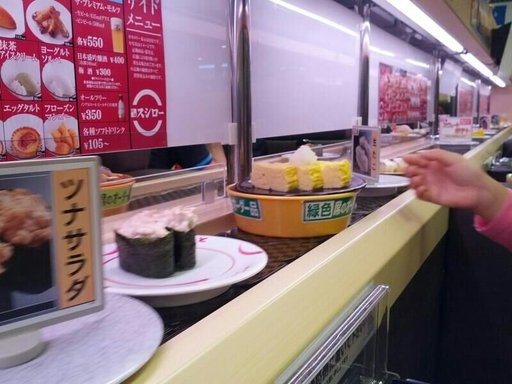

In [68]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

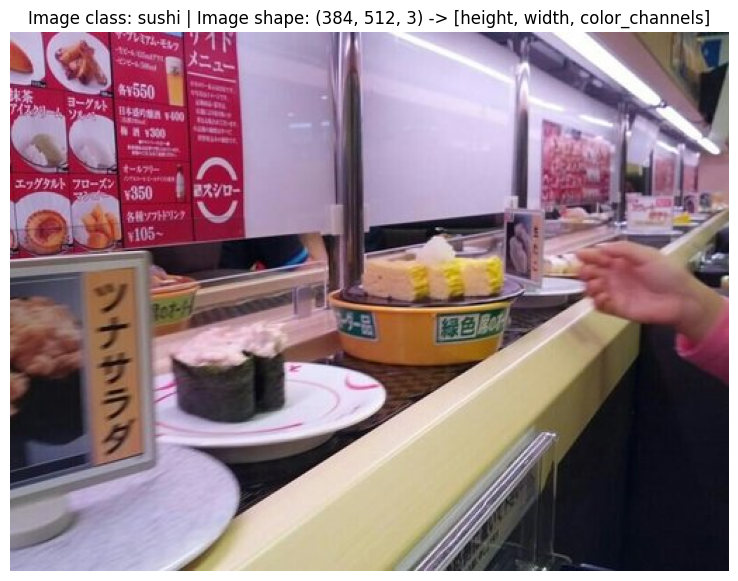

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [70]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [71]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Now we've got a composition of transforms, let's write a function to try them out on various images.

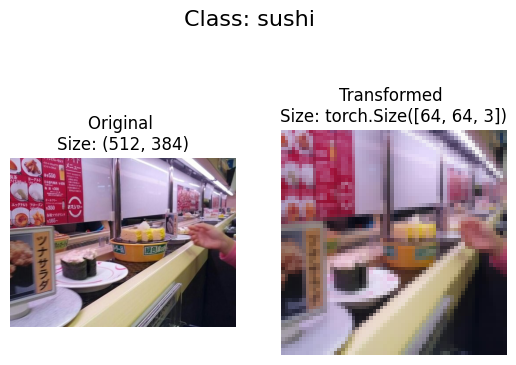

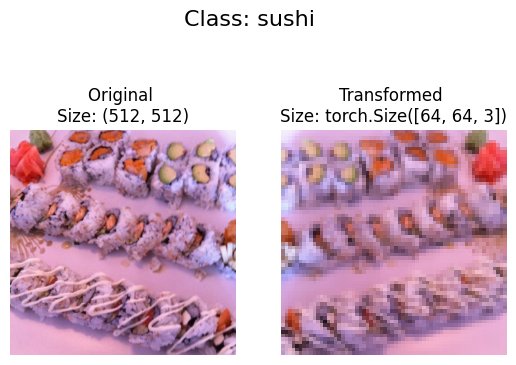

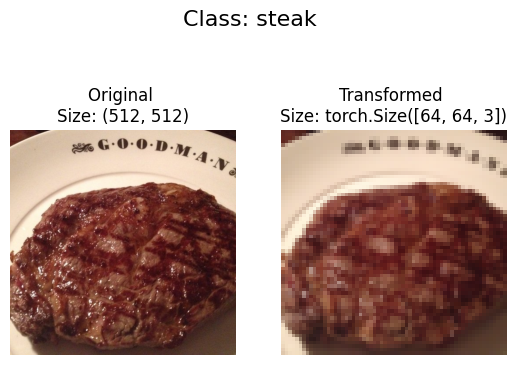

In [72]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

Nice!

We've now got a way to convert our images to tensors using `torchvision.transforms`.

We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`).

However, the tradeoff is that more pixels requires more computations.

> **Exercise:** Try commenting out one of the transforms in `data_transform` and running the plotting function `plot_transformed_images()` again, what happens?

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.

In [73]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Beautiful!

It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

In [74]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [75]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [76]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

Nice! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [77]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


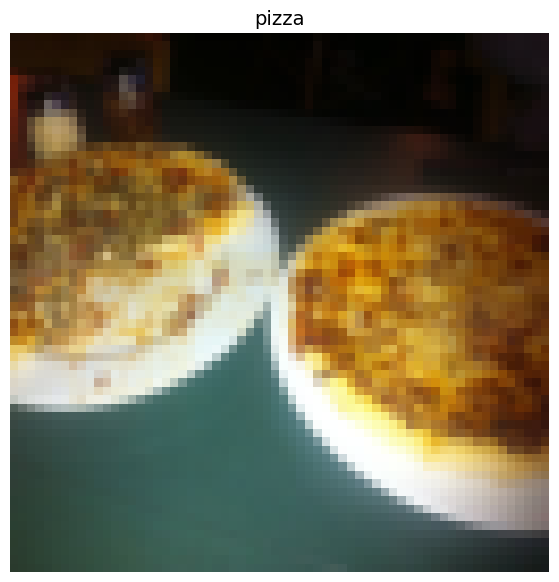

In [78]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Notice the image is now more pixelated (less quality).

This is due to it being resized from `512x512` to `64x64` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

### 4.1 Turn loaded images into `DataLoader`'s

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

We'll do so using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers`?

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count).

This ensures the `DataLoader` recruits as many cores as possible to load data.

> **Note:** There are more parameters you can get familiar with using `torch.utils.data.DataLoader` in the [PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [79]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d7e5e495790>,
 <torch.utils.data.dataloader.DataLoader at 0x7d7e88e84650>)

Wonderful!

Now our data is iterable.

Let's try it out and check the shapes.

In [80]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

## 5. Option 2: Loading Image Data with a Custom `Dataset`

What if a pre-built `Dataset` creator like [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. |
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [81]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [82]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [83]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


Excellent!

How about we turn it into a full function?

In [84]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Looking good!

Now let's test out our `find_classes()` function.

In [85]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Woohoo! Looking good!

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Now we're ready to build our own custom `Dataset`.

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`.

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom `Dataset`.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

Let's do it!

In [86]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

Woah! A whole bunch of code to load in our images.

This is one of the downsides of creating your own custom `Dataset`'s.

However, now we've written it once, we could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on.

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.

In [87]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Now comes the moment of truth!

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [88]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d7e88d18560>,
 <__main__.ImageFolderCustom at 0x7d7e88d072c0>)

Hmm... no errors, did it work?

Let's try calling `len()` on our new `Dataset`'s and find the `classes` and `class_to_idx` attributes.

In [89]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [90]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [91]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

`len(test_data_custom) == len(test_data)` and `len(test_data_custom) == len(test_data)` Yes!!!

It looks like it worked.

We could check for equality with the `Dataset`'s made by the `torchvision.datasets.ImageFolder()` class too.

In [92]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


Ho ho!

Look at us go!

Three `True`'s!

You can't get much better than that.

How about we take it up a notch and plot some random images to test our `__getitem__` override?

### 5.3 Create a function to display random images

You know what time it is!

Time to put on our data explorer's hat and *visualize, visualize, visualize!*

Let's create a helper function called `display_random_images()` that helps us visualize images in our `Dataset'`s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed.
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [93]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

What a good looking function!

Let's test it out first with the `Dataset` we created with `torchvision.datasets.ImageFolder()`.

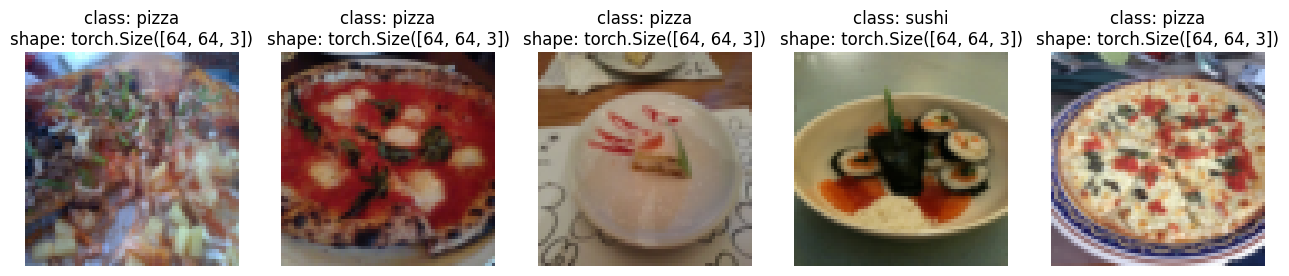

In [94]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

And now with the `Dataset` we created with our own `ImageFolderCustom`.

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


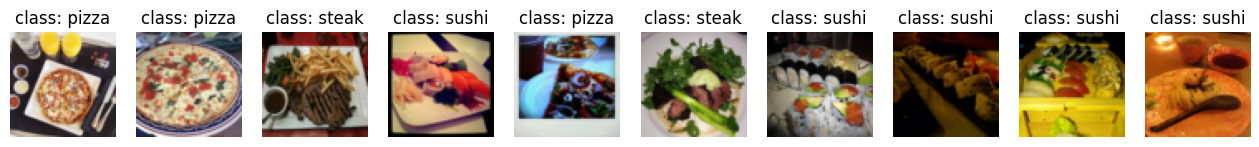

In [95]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

Nice!!!

Looks like our `ImageFolderCustom` is working just as we'd like it to.

### 5.4 Turn custom loaded images into `DataLoader`'s

We've got a way to turn our raw images into `Dataset`'s (features mapped to labels or `X`'s mapped to `y`'s) through our `ImageFolderCustom` class.

Now how could we turn our custom `Dataset`'s into `DataLoader`'s?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [96]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d7e884518e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d7e88e73e90>)

Do the shapes of the samples look the same?

In [97]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


They sure do!

Let's now take a look at some other forms of data transforms.

## 6. Other forms of transforms (data augmentation)

We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the [`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).

The purpose of tranforms is to alter your images in some way.

That may be turning your images into a tensor (as we've seen before).

Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as **data augmentation**.

**Data augmentation** is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully results in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using `torchvision.transforms` in PyTorch's [Illustration of Transforms example](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html).

But let's try one out ourselves.

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The PyTorch team even [used TrivialAugment it to train their latest state-of-the-art vision models](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements).

![trivial augment data augmentation being used for PyTorch state of the art training](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-trivial-augment-being-using-in-PyTorch-resize.png)

*TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.*

How about we test it out on some of our own images?

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity).

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

In [98]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

> **Note:** You usually don't perform data augmentation on the test set. The idea of data augmentation is to to *artificially* increase the diversity of the training set to better predict on the testing set.
>
> However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out!

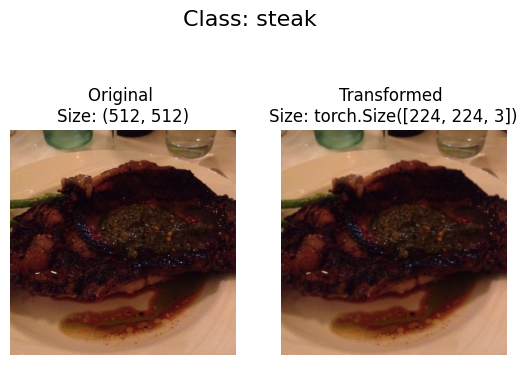

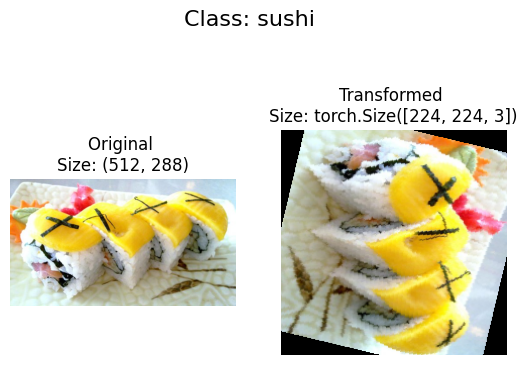

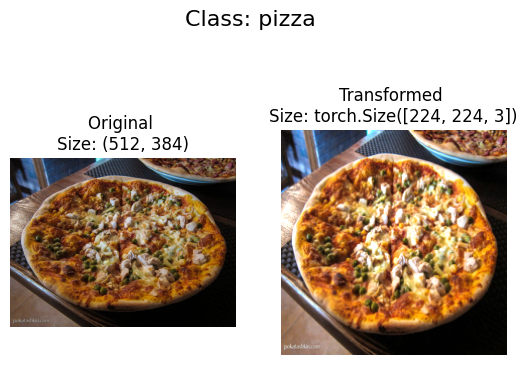

In [99]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

Try running the cell above a few times and seeing how the original image changes as it goes through the transform.

## 7. Model 0: TinyVGG without data augmentation

Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

### 7.1 Creating transforms and loading data for Model 0

In [100]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Excellent, now we've got a simple transform, let's:
1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()`
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
    * We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [101]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7d7e740539e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d7e88188f20>)

`DataLoader`'s created!

Let's build a model.

### 7.2 Create TinyVGG model class

In [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn), we used the TinyVGG model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

Let's recreate the same model, except this time we'll be using color images instead of grayscale (`in_channels=3` instead of `in_channels=1` for RGB pixels).

In [102]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **Note:** One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
>
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
>
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
>
> See [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.

Now that's a nice looking model!

How about we test it out with a forward pass on a single image?



### 7.3 Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:
1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [103]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


Wonderful, it looks like our model is outputting what we'd expect it to output.

You can run the cell above a few times and each time have a different image be predicted on.

And you'll probably notice the predictions are often wrong.

This is to be expected because the model hasn't been trained yet and it's essentially guessing using random weights.

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

> **Note:** If you're using Google Colab, you'll need to install `torchinfo`.

In [104]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

Nice!

The output of `torchinfo.summary()` gives us a whole bunch of information about our model.

Such as `Total params`, the total number of parameters in our model, the `Estimated Total Size (MB)` which is the size of our model.

You can also see the change in input and output shapes as data of a certain `input_size` moves through our model.

Right now, our parameter numbers and total model size is low.

This because we're starting with a small model.

And if we need to increase its size later, we can.

### 7.5 Create train & test loop functions

We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

> **Note:** We covered the steps in a PyTorch opimization loop in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-an-optimization-loop-in-pytorch), as well as the[ Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) and we've built similar functions in [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#62-functionizing-training-and-test-loops).

Let's start by building `train_step()`.

Because we're dealing with batches in the `DataLoader`'s, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust them at the end before we return them.

In [105]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Woohoo! `train_step()` function done.

Now let's do the same for the `test_step()` function.

The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

But since we'll be doing inference, we'll make sure to turn on the `torch.inference_mode()` context manager for making predictions.

In [106]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Excellent!



### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [107]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `TinyVGG` model, `DataLoader`'s and `train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model_0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-3` respectively.

To see how long things take, we'll import Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) method to calculate the training time.

In [108]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1696 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.4141 | test_loss: 1.1344 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 11.304 seconds


Hmm...

It looks like our model performed pretty poorly.

But that's okay for now, we'll keep persevering.

What are some ways you could potentially improve it?

> **Note:** Check out the [*Improving a model (from a model perspective)* section in notebook 02](https://www.learnpytorch.io/02_pytorch_classification/#5-improving-a-model-from-a-model-perspective) for ideas on improving our TinyVGG model.

### 7.8 Plot the loss curves of Model 0

From the print outs of our `model_0` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**.

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.

In [109]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

We'll need to extract each of these keys and turn them into a plot.

In [110]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Okay, let's test our `plot_loss_curves()` function out.

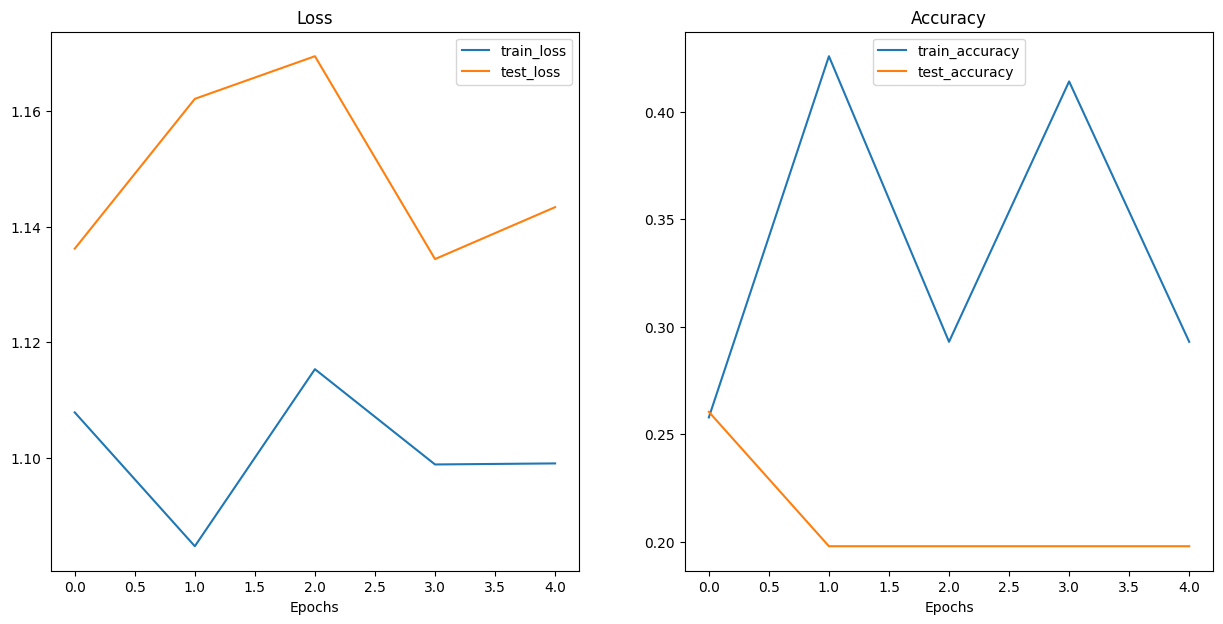

In [111]:
plot_loss_curves(model_0_results)

Woah.

Looks like things are all over the place...

But we kind of knew that because our model's print out results during training didn't show much promise.

You could try training the model for longer and see what happens when you plot a loss curve over a longer time horizon.

## 8. What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### 8.1 How to deal with overfitting

Since the main problem with overfitting is that your model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

### 8.2 How to deal with underfitting

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### 8.3 The balance between overfitting and underfitting

None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everyone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

## 9. Model 1: TinyVGG with Data Augmentation

Time to try out another model!

This time, let's load in the data and use **data augmentation** to see if it improves our results in anyway.

First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

### 9.1 Create transform with data augmentation

In [112]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Wonderful!

Now let's turn our images into `Dataset`'s using `torchvision.datasets.ImageFolder()` and then into `DataLoader`'s with `torch.utils.data.DataLoader()`.

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s

We'll make sure the train `Dataset` uses the `train_transform_trivial_augment` and the test `Dataset` uses the `test_transform`.

In [113]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

And we'll make `DataLoader`'s with a `batch_size=32` and with `num_workers` set to the number of CPUs available on our machine (we can get this using Python's `os.cpu_count()`).

In [114]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d7e882b1af0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d7e88e84650>)

### 9.3 Construct and train Model 1

Data loaded!

Now to build our next model, `model_1`, we can reuse our `TinyVGG` class from before.

We'll make sure to send it to the target device.

In [115]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Model ready!

Time to train!

Since we've already got functions for the training loop (`train_step()`) and testing loop (`test_step()`) and a function to put them together in `train()`, let's reuse those.

We'll use the same setup as `model_0` with only the `train_dataloader` parameter varying:
* Train for 5 epochs.
* Use `train_dataloader=train_dataloader_augmented` as the training data in `train()`.
* Use `torch.nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification).
* Use `torch.optim.Adam()` with `lr=0.001` as the learning rate as the optimizer.                                                          

In [116]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1292 | train_acc: 0.3047 | test_loss: 1.1624 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1481 | test_acc: 0.2604
Total training time: 6.277 seconds


Hmm...

It doesn't look like our model performed very well again.

Let's check out its loss curves.

### 9.4 Plot the loss curves of Model 1

Since we've got the results of `model_1` saved in a results dictionary, `model_1_results`, we can plot them using `plot_loss_curves()`.

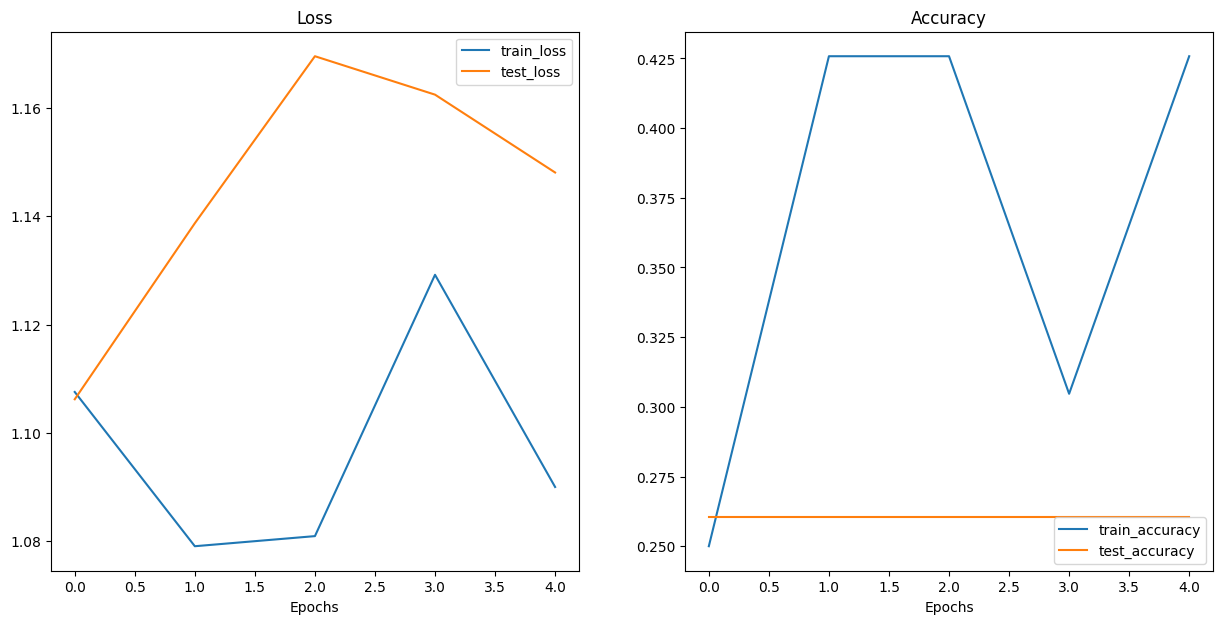

In [117]:
plot_loss_curves(model_1_results)

Wow...

These don't look very good either...

Is our model **underfitting** or **overfitting**?

Or both?

Ideally we'd like it have higher accuracy and lower loss right?

What are some methods you could try to use to achieve these?

## 10. Compare model results

Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results into pandas DataFrames.

In [118]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115324,0.292969,1.169554,0.197917
3,1.098812,0.414062,1.134404,0.197917
4,1.098995,0.292969,1.143399,0.197917


And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

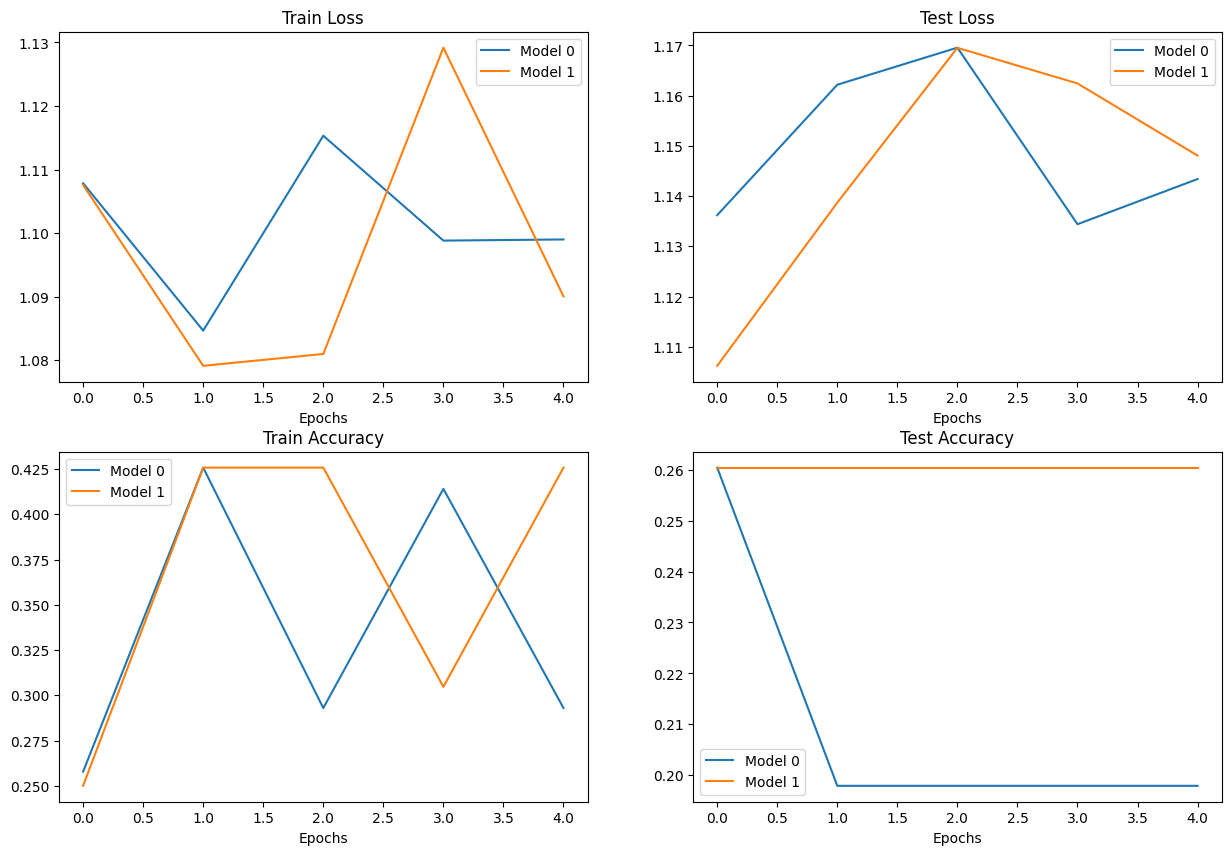

In [119]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

It looks like our models both performed equally poorly and were kind of sporadic (the metrics go up and down sharply).

If you built `model_2`, what would you do differently to try and improve performance?

## 11. Make a prediction on a custom image

If you've trained a model on a certain dataset, chances are you'd like to make a prediction on your own custom data.

In our case, since we've trained a model on pizza, steak and sushi images, how could we use our model to make a prediction on one of our own images?

To do so, we can load an image and then **preprocess it in a way that matches the type of data our model was trained on**.

In other words, we'll have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

Let's start by downloading a custom image.

Since our model predicts whether an image contains pizza, steak or sushi, let's download a photo of [my Dad giving two thumbs up to a big pizza from the Learn PyTorch for Deep Learning GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg).

We download the image using Python's `requests` module.

> **Note:** If you're using Google Colab, you can also upload an image to the current session by going to the left hand side menu -> Files -> Upload to session storage. Beware though, this image will delete when your Google Colab session ends.


In [120]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch

Excellent!

Looks like we've got a custom image downloaded and ready to go at `data/04-pizza-dad.jpeg`.

Time to load it in.

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in [`torchvision.io`](https://pytorch.org/vision/stable/io.html).

Since we want to load in an image, we'll use [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype `uint8` in range `[0, 255]`.

Let's try it out.

In [121]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

Nice! Looks like our image is in tensor format, however, is this image format compatible with our model?

Our `custom_image` tensor is of datatype `torch.uint8` and its values are between `[0, 255]`.

But our model takes image tensors of datatype `torch.float32` and with values between `[0, 1]`.

So before we use our custom image with our model, **we'll need to convert it to the same format as the data our model is trained on**.

If we don't do this, our model will error.

In [122]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

Let's fix this by converting our custom image to the same datatype as what our model was trained on (`torch.float32`).

In [123]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on custom images with a trained PyTorch model

Beautiful, it looks like our image data is now in the same format our model was trained on.

Except for one thing...

It's `shape`.

Our model was trained on images with shape `[3, 64, 64]`, whereas our custom image is currently `[3, 4032, 3024]`.

How could we make sure our custom image is the same shape as the images our model was trained on?

Are there any `torchvision.transforms` that could help?

Before we answer that question, let's plot the image with `matplotlib` to make sure it looks okay, remember we'll have to permute the dimensions from `CHW` to `HWC` to suit `matplotlib`'s requirements.

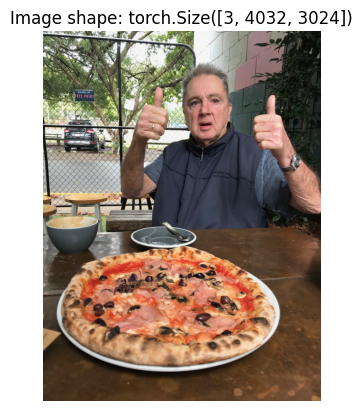

In [124]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

Two thumbs up!

Now how could we get our image to be the same size as the images our model was trained on?

One way to do so is with `torchvision.transforms.Resize()`.

Let's compose a transform pipeline to do so.

In [125]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


Woohoo!

Let's finally make a prediction on our own custom image.

In [126]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

Oh my goodness...

Despite our preparations our custom image and model are on different devices.

And we get the error:

> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)`

Let's fix that by putting our `custom_image_transformed` on the target device.

In [127]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

What now?

It looks like we're getting a shape error.

Why might this be?

We converted our custom image to be the same size as the images our model was trained on...

Oh wait...

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (`NCHW` where `N` is the batch size).

Except our custom image is currently only `CHW`.

We can add a batch size dimension using `torch.unsqueeze(dim=0)` to add an extra dimension our image and *finally* make a prediction.

Essentially we'll be telling our model to predict on a single image (an image with a `batch_size` of 1).

In [128]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


Yes!!!

It looks like it worked!

> **Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:
> 1. **Wrong datatypes** - our model expects `torch.float32` where our original custom image was `uint8`.
> 2. **Wrong device** - our model was on the target `device` (in our case, the GPU) whereas our target data hadn't been moved to the target `device` yet.
> 3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.
>
> Keep in mind, these errors aren't just for predicting on custom images.
>
> They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.

Now let's take a look at our model's predictions.

In [129]:
custom_image_pred

tensor([[ 0.1188,  0.0339, -0.1480]])

Alright, these are still in *logit form* (the raw outputs of a model are called logits).

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [130]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1188,  0.0339, -0.1480]])
Prediction probabilities: tensor([[0.3725, 0.3422, 0.2853]])
Prediction label: tensor([0])


Alright!

Looking good.

But of course our prediction label is still in index/tensor form.

We can convert it to a string class name prediction by indexing on the `class_names` list.

In [131]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

Wow.

It looks like the model gets the prediction right, even though it was performing poorly based on our evaluation metrics.

> **Note:** The model in its current form will predict "pizza", "steak" or "sushi" no matter what image it's given. If you wanted your model to predict on a different class, you'd have to train it to do so.

But if we check the `custom_image_pred_probs`, we'll notice that the model gives almost equal weight (the values are similar) to every class.

In [132]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3725, 0.3422, 0.2853]])

Having prediction probabilities this similar could mean a couple of things:
1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

Our case is number 2, since our model is poorly trained, it is basically *guessing* the prediction.

### 11.3 Putting custom image prediction together: building a function

Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

A fair few steps but we've got this!

In [133]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

What a nice looking function, let's test it out.

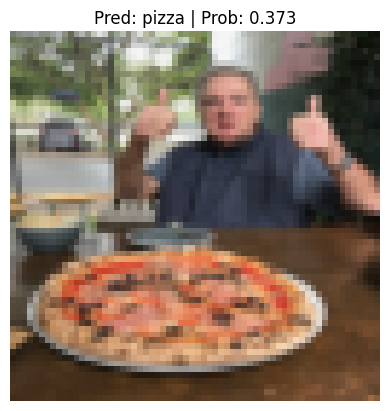

In [134]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

Two thumbs up again!

Looks like our model got the prediction right just by guessing.

This won't always be the case with other images though...

The image is pixelated too because we resized it to `[64, 64]` using `custom_image_transform`.

> **Exercise:** Try making a prediction with one of your own images of pizza, steak or sushi and see what happens.

## Main takeaways

We've covered a fair bit in this module.

Let's summarise it with a few dot points.

* PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems.
* If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing `torch.utils.data.Dataset`.
* `torch.utils.data.DataLoader`'s in PyTorch help turn your `Dataset`'s into iterables that can be used when training and testing a model.
* A lot of machine learning is dealing with the balance between **overfitting** and **underfitting** (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques).
* Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:
    1. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8`.
    2. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.
    3. **Wrong devices** - Your model is on the GPU but your data is on the CPU.

## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb)
* [Example solutions notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.
2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test `DataLoader`'s ready to use.
3. Recreate `model_0` we built in section 7.
4. Create training and testing functions for `model_0`.
5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
    * Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.
6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?
7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
    * **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
    * You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.
8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
    * Does the model you trained in exercise 7 get it right?
    * If not, what do you think you could do to improve it?

## Extra-curriculum

* To practice your knowledge of PyTorch `Dataset`'s and `DataLoader`'s through PyTorch [datasets and dataloaders tutorial notebook](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
* Spend 10-minutes reading the [PyTorch `torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).
    * You can see demos of transforms in action in the [illustrations of transforms tutorial](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html).
* Spend 10-minutes reading the PyTorch [`torchvision.datasets` documentation](https://pytorch.org/vision/stable/datasets.html).
    * What are some datasets that stand out to you?
    * How could you try building a model on these?
* [TorchData is currently in beta](https://pytorch.org/data/beta/index.html) (as of April 2022), it'll be a future way of loading data in PyTorch, but you can start to check it out now.
* To speed up deep learning models, you can do a few tricks to improve compute, memory and overhead computations, for more read the post [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He.